In [1]:
#information allowing anyone with the code to print the author and contact information
__author__    = "Quenton Haffner,Devyn "
__contact__   = "quenton.haffner@und.edu"


In [2]:
#import librauys
import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout
from metpy.io import metar

import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from metpy.plots import wx_code_to_numeric

In [3]:
#data read in for surface plots

data = Dataset('20211211_0500')
station = data.variables['stationName'][:]
latitude = data.variables['latitude'][:]
longitude = data.variables['longitude'][:]
temp = (data.variables['temperature'][:]-273.15)*(9/5)+32.0
dew = (data.variables['dewpoint'][:]-273.15)*(9/5)+32.0
dir = data.variables['windDir'][:]
wspeed = data.variables['windSpeed'][:]
gust = data.variables['windGust'][:]
weather = data.variables['presWeather'][:]
vis = data.variables['visibility'][:]
pslp = data.variables['seaLevelPress'][:]/100 #converts to hPa
skycover = data.variables['skyCover'][:]
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    cdlDate: 20160212
    idVariables: stationName
    timeVariables: timeObs
    filePeriod: 3600
    fileEndOffset: 2699
    Conventions: MADIS surface observations, v1.0
    title: MADIS - Meteorological Surface - METAR
    startTime: 2021-12-11T04:45:00Z
    endTime: 2021-12-11T05:44:59Z
    stationIdVariable: stationName
    stationDescriptionVariable: locationName
    stationLocationVariables: latitude,longitude,elevation
    standard_name_vocabulary: CF
    id: MADIS_METAR
    naming_authority: noaa.gov
    thredds_data_type: Station
    history: revision: 1.5; date: 2016/02/12; author: benjamin
    creator_name: Michael F. Barth
    creator_url: https://madis.ncep.noaa.gov
    creator_email: madis-support@noaa.gov
    project: Meteorological Assimilation Data Ingest System (MADIS)
    geospatial_lat_min: -5
    geospatial_lat_max: 85
    geospatial_lon_min: -180
    geospatial_lon_m

/home/quenton.haffner/miniconda3/envs/atsc270/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [7]:
#convert from byte array to list of string
stn_names = ['']*len(station)
for index in range (len(station)):
    stn = station[index].tobytes().decode().rstrip('\x00')
    stn_names[index] = stn
    
cur_wx = [''] * len(weather)
for index in range (len(weather)):
    wx = weather[index].tobytes().decode().rstrip('\x00')
    cur_wx[index] = wx
#converts strings to the weather codes
wx_code = wx_code_to_numeric(cur_wx)


sky_num = np.empty(len(skycover),dtype=int)
for i in range(len(skycover)):
    this_sky = skycover[i].tobytes().decode().rstrip('\x00')
    if this_sky[-3:] == 'SKC' or this_sky[-3:] == 'CLR':
        sky_cover[i] = 0
    elif this_sky[-3:] == 'FEW':
        sky_cover[i] = 2
    elif this_sky[-3:] == 'SCT':
        sky_cover[i] = 4
    elif this_sky[-3:] == 'BRK':
        sky_cover[i] = 6
    elif this_sky[-3:] == 'OVC':
        sky_cover[i] = 8
    else:
        sky_cover[i] = 10
    

    #if skc = 0
#if few = 2/8
#if sct = 4/8
#broken if 6/8
#over if 8/8
    
#wind calculation
wspd_from_data = np.array(wspeed)*units('m/s')
wdir_from_data = np.array(dir)*units('m/s')
u,v = mpcalc.wind_components(wspd_from_data,wdir_from_data)

TypeError: 'CodePointMapping' object does not support item assignment

In [51]:
#pd data frame
data_for_df = {'station_id':stn_names,
               'latitude':latitude,
               'longitude':latitude,
               'wind_direction':dir,
               'wind_speed':wspeed,
               'wind_gust':gust,
               'visibility':vis,
               'current_wx1_symbol':wx_code,
               'air_temperature':temp,
               'dew_point_temperature':dew,
               'air_pressure_at_sea_level':pslp}
data = pd.DataFrame(data_for_df,index=stn_names)
print(data)

     station_id   latitude  longitude  wind_direction  wind_speed  wind_gust  \
NZCM       NZCM -77.870003 -77.870003            80.0         5.1        NaN   
SAWE       SAWE -53.799999 -53.799999            90.0         5.7        NaN   
SULS       SULS -34.860001 -34.860001            70.0         2.6        NaN   
SUMU       SUMU -34.830002 -34.830002            50.0         2.6        NaN   
SCEL       SCEL -33.380001 -33.380001           160.0         3.6        NaN   
...         ...        ...        ...             ...         ...        ...   
KEWB       KEWB  41.680000  41.680000            40.0         1.5        NaN   
KBVY       KBVY  42.580002  42.580002           340.0         2.6        NaN   
CYFC       CYFC  45.860001  45.860001             0.0         0.0        NaN   
CWEF       CWEF  47.230000  47.230000             NaN         NaN        NaN   
CWST       CWST  47.349998  47.349998            60.0         1.0        NaN   

      visibility  current_wx1_symbol  a

In [52]:
#convert to F temp
data.air_temperature = data.air_temperature * 1.8 +32
data.dew_point_temperature = data.dew_point_temperature * 1.8 +32
#drop missing values
data = data.dropna(how='any',subset=['wind_direction','wind_speed'])


In [54]:
#rethin data (90km works well)
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)
data_thinned = data[mpcalc.reduce_point_density(locs, 90000, priority=None)]

In [ ]:
u = []
v = []
for i in range(len()):
    
    thisu,thisv = wind_components(kts_subset[i],drct_subset[i])
    u.append(thisu)
    v.append(thisv)

In [56]:
#create wind gust vectors
#do this by multiplying each component by the ratio of gust to speed
u = data_thinned.eastward_wind.values * units('knots')
v = data_thinned.northward_wind.values * units('knots')
gust = data_thinned.wind_gust.values * units('knots')
direction = mpcalc.wind_direction(u,v)
gustu,gustv = mpcalc.wind_components(gust,direction)


AttributeError: 'DataFrame' object has no attribute 'eastward_wind'

NameError: name 'gustu' is not defined

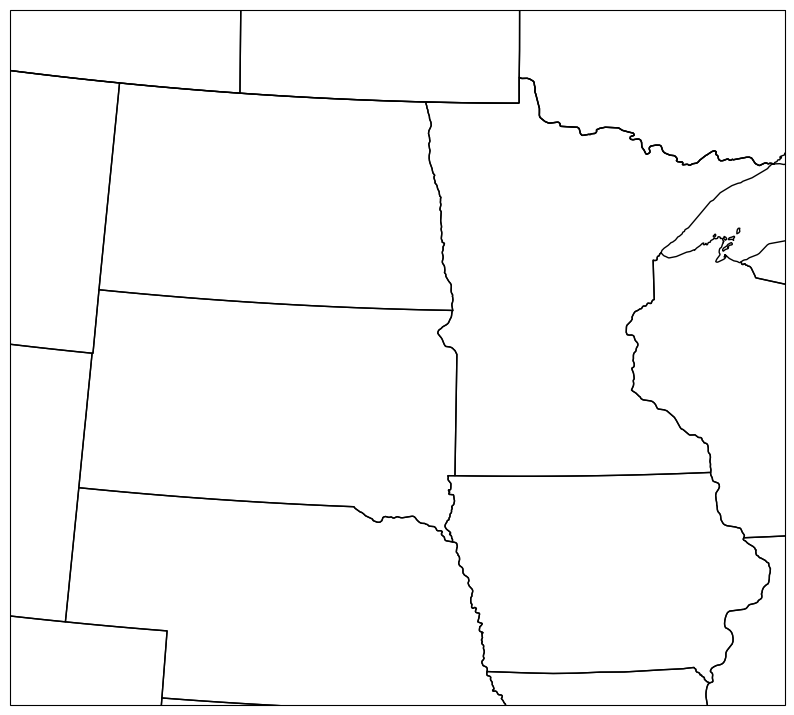

In [57]:
#map projection
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Northern Plains
ax.set_extent((-105, -90, 40, 50))


#create stationplot (will actually need to create 2 to handle wind gusts)
stationplot = StationPlot(ax, data_thinned['longitude'].values, data_thinned['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=7)
stationplot2 = StationPlot(ax, data_thinned['longitude'].values, data_thinned['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=7)
#temperature in red
stationplot.plot_parameter('NW', data_thinned['air_temperature'].values, color='red')
#dewpoint in dark green
stationplot.plot_parameter('SW', data_thinned['dew_point_temperature'].values,
                           color='darkgreen')
#pressure (need to format to be the final 3 digits)
# in tenths of millibars.
stationplot.plot_parameter('NE', data_thinned['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])
#station ID in dark blue
stationplot.plot_text((2, 0), data_thinned['station_id'].values,color='darkblue')
#visibility in black (need to convert from meters to miles)

#wind gust in red
stationplot2.plot_barb(gustu, gustv,color='red')
#wind in black
stationplot.plot_barb(data_thinned.eastward_wind, data_thinned.northward_wind)
#cloud cover
stationplot.plot_symbol('C', data_thinned['cloud_coverage'].values, sky_cover)
#current weather
stationplot.plot_symbol('W', data_thinned['current_wx1_symbol'].values, current_weather)
#save the map as surface_obs.png
plt.savefig('surface_obs.png')